In [2]:
#import library yang dibutuhkan
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permiss

kaggle.json


In [4]:
! kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

 97% 366M/376M [00:04<00:00, 109MB/s]
100% 376M/376M [00:04<00:00, 84.0MB/s]


In [5]:
#unzip file 
import os
!unzip /content/animal-image-datasetdog-cat-and-panda.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: animals/animals/dogs/dogs_00008.jpg  
  inflating: animals/animals/dogs/dogs_00009.jpg  
  inflating: animals/animals/dogs/dogs_00010.jpg  
  inflating: animals/animals/dogs/dogs_00011.jpg  
  inflating: animals/animals/dogs/dogs_00012.jpg  
  inflating: animals/animals/dogs/dogs_00013.jpg  
  inflating: animals/animals/dogs/dogs_00014.jpg  
  inflating: animals/animals/dogs/dogs_00015.jpg  
  inflating: animals/animals/dogs/dogs_00016.jpg  
  inflating: animals/animals/dogs/dogs_00017.jpg  
  inflating: animals/animals/dogs/dogs_00018.jpg  
  inflating: animals/animals/dogs/dogs_00019.jpg  
  inflating: animals/animals/dogs/dogs_00020.jpg  
  inflating: animals/animals/dogs/dogs_00021.jpg  
  inflating: animals/animals/dogs/dogs_00022.jpg  
  inflating: animals/animals/dogs/dogs_00023.jpg  
  inflating: animals/animals/dogs/dogs_00024.jpg  
  inflating: animals/animals/dogs/dogs_00025.jpg  
  inflating: animals/an

In [6]:
os.listdir('/content/animals/animals')

['dogs', 'cats', 'panda']

In [7]:
base_dir = '/content/animals/animals'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'val')

In [8]:
# membuat direktori train dan validation (dijalankan hanya sekali)
os.mkdir(train_dir)
os.mkdir(validation_dir)

In [9]:
#cek lagi
os.listdir('/content/animals/animals')

['val', 'dogs', 'cats', 'train', 'panda']

In [10]:
dogs_dir = os.path.join(base_dir,'dogs')
cats_dir = os.path.join(base_dir, 'cats')
panda_dir = os.path.join(base_dir, 'panda')

In [11]:
#memecah direktori rock,scissors dan paper masing2 menjadi data train dan data validation
train_dogs_dir, val_dogs_dir = train_test_split(os.listdir(dogs_dir),train_size =0.8, test_size = 0.2)
train_cats_dir, val_cats_dir = train_test_split(os.listdir(cats_dir),train_size =0.8, test_size = 0.2)
train_panda_dir, val_panda_dir = train_test_split(os.listdir(panda_dir),train_size =0.8, test_size = 0.2)


In [13]:
train_dogs = os.path.join(train_dir, 'dogs')
val_dogs = os.path.join(validation_dir, 'dogs')
train_cats = os.path.join(train_dir, 'cats')
val_cats = os.path.join(validation_dir, 'cats')
train_panda = os.path.join(train_dir, 'panda')
val_panda = os.path.join(validation_dir, 'panda')

# membuat directory baru di dalam directory train dan val masing-masing
if not os.path.exists(train_dogs):
  os.mkdir(train_dogs)
if not os.path.exists(val_dogs):
  os.mkdir(val_dogs)

if not os.path.exists(train_cats):
  os.mkdir(train_cats)
if not os.path.exists(val_cats):
  os.mkdir(val_cats)

if not os.path.exists(train_panda):
  os.mkdir(train_panda)
if not os.path.exists(val_panda):
  os.mkdir(val_panda)





In [14]:
# mengcopy data train dan data val ke directory baru dengan librari shutil
import shutil

for a in train_dogs_dir:
  shutil.copy(os.path.join(dogs_dir, a), os.path.join(train_dogs, a))
for a in train_cats_dir:
  shutil.copy(os.path.join(cats_dir,a), os.path.join(train_cats,a))
for a in train_panda_dir:
  shutil.copy(os.path.join(panda_dir,a), os.path.join(train_panda,a))

for a in val_dogs_dir:
  shutil.copy(os.path.join(dogs_dir, a), os.path.join(val_dogs,a))
for a in val_cats_dir:
  shutil.copy(os.path.join(cats_dir,a), os.path.join(val_cats,a))
for a in val_panda_dir:
  shutil.copy(os.path.join(panda_dir,a), os.path.join(val_panda,a))

In [15]:
#membuat sebuah objek ImageDataGenerator untuk data training dan data testing

train_datagen = ImageDataGenerator(
    rescale = 1./225,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest')

test_datagen = ImageDataGenerator( 
    rescale = 1./225, 
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest')

In [36]:
#menggunakan objek image data generator sebelumnya untuk mempersiapkan data latih yang akan dipelajari oleh model.

# split into train and test
train_generator = train_datagen.flow_from_directory(
    train_dir, #direktori data latih
    target_size=(100, 100), #mengubah resolusi seluruh gambar menjadi 100x100 pixels
    batch_size =32,
    #melakukan masalah klasifikasi 3 kelas maka menggunakan class_mode ='Categorical'
    class_mode ='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir, #direktori data validasi
    target_size=(100, 100),
    batch_size=32,
    class_mode = 'categorical')

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [56]:
#mendefinisikan model
model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(100, 100, 3))),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    #flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),

    #512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.layers[0].trainable = False

In [57]:
#compile model
model.compile(loss='categorical_crossentropy',
              optimizer= 'RMSprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 4, 4, 2048)        58331648  
_________________________________________________________________
dropout_12 (Dropout)         (None, 4, 4, 2048)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 2, 2, 16)          294928    
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               8704      
_________________________________________________________________
dense_40 (Dense)             (None, 256)             

In [58]:
#menggunakan fungsi callback
class stopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
      print('\nAkurasi telah mencapai >92%!')
      self.model.stop_training = True

panggil = stopTraining()

In [59]:
#fit / training model
history = model.fit(
    train_generator,
    steps_per_epoch = 25,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 5,
    verbose =2,
    callbacks=[panggil])

Epoch 1/30
25/25 - 11s - loss: 1.3094 - accuracy: 0.6662 - val_loss: 0.4658 - val_accuracy: 0.8625
Epoch 2/30
25/25 - 8s - loss: 0.3584 - accuracy: 0.8512 - val_loss: 0.3611 - val_accuracy: 0.8562
Epoch 3/30
25/25 - 8s - loss: 0.3369 - accuracy: 0.8813 - val_loss: 0.3787 - val_accuracy: 0.8375
Epoch 4/30
25/25 - 8s - loss: 0.3254 - accuracy: 0.8662 - val_loss: 0.2506 - val_accuracy: 0.9062
Epoch 5/30
25/25 - 8s - loss: 0.3488 - accuracy: 0.8650 - val_loss: 0.3494 - val_accuracy: 0.8562
Epoch 6/30
25/25 - 8s - loss: 0.2974 - accuracy: 0.9038 - val_loss: 0.2987 - val_accuracy: 0.8875
Epoch 7/30
25/25 - 8s - loss: 0.2892 - accuracy: 0.9087 - val_loss: 0.2259 - val_accuracy: 0.9250
Epoch 8/30
25/25 - 8s - loss: 0.2581 - accuracy: 0.9000 - val_loss: 0.3153 - val_accuracy: 0.8625
Epoch 9/30
25/25 - 8s - loss: 0.2422 - accuracy: 0.9087 - val_loss: 0.3066 - val_accuracy: 0.8750
Epoch 10/30
25/25 - 8s - loss: 0.2677 - accuracy: 0.8975 - val_loss: 0.3141 - val_accuracy: 0.8625
Epoch 11/30
25/25 

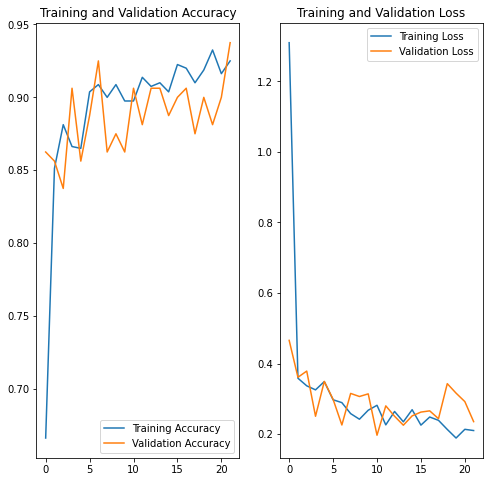

In [60]:
# memvisualisasikan hasil data training 

import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(22)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Saving kucing.jpg to kucing (1).jpg
Ini gambar kucing 


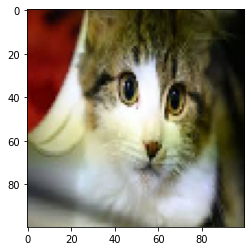

In [61]:
import numpy as np
from google.colab import files 
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

 
uploaded = files.upload()
 
for test in uploaded.keys():
 
  # predicting images
  path = test
  img = image.load_img(path, target_size=(100,100))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  if classes [0,0] !=0:
    print('Ini gambar kucing ')
  elif classes [0,1] !=0:
    print('anjing')
  else:
    print('panda')

In [62]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpd_qi_rzy/assets


INFO:tensorflow:Assets written to: /tmp/tmpd_qi_rzy/assets


In [63]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)